#### CSE 252A Computer Vision I Fall 2021 - Assignment 2

In [4]:
import numpy as np
from time import time
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [10]:
# Open image as grayscale
img = io.imread('dog.jpg', as_gray=True)

In [6]:
def zero_pad(image, pad_top, pad_down, pad_left, pad_right):
    """ Zero-pad an image.

    Ex: a 1x1 image [[1]] with pad_top = 1, pad_down = 1, pad_left = 2, pad_right = 2 becomes:

        [[0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0]]         of shape (3, 5)

    Args:
        image: numpy array of shape (H, W)
        pad_left: width of the zero padding to the left of the first column
        pad_right: width of the zero padding to the right of the last column
        pad_top: height of the zero padding above the first row
        pad_down: height of the zero padding below the last row

    Returns:
        out: numpy array of shape (H + pad_top + pad_down, W + pad_left + pad_right)
    """
    
    left=np.zeros((image.shape[0],pad_left))
    right=np.zeros((image.shape[0], pad_right))
   
    out=np.concatenate((left,image,right), axis=1)

    up=np.zeros((pad_top, out.shape[1]))
    down=np.zeros((pad_down, out.shape[1]))
    out=np.concatenate((up,out,down), axis=0)

    return out

### Implementing Convolution

In [8]:
def conv(image, kernel):
    """ An efficient implementation of a convolution filter.

    This function uses element-wise multiplication and np.sum()
    to efficiently compute a weighted sum of the neighborhood at each
    pixel.

    Args:
        image: numpy array of shape (Hi, Wi)
        kernel: numpy array of shape (Hk, Wk)

    Returns:
        out: numpy array of shape (Hi, Wi)
    """
    
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    padded_img = zero_pad(image, Hk//2, Hk-Hk//2-1, Wk//2, Wk-Wk//2-1)
    out = np.zeros((Hi, Wi))
    
    flip_kernel = np.flip(np.flip(kernel, axis=0), axis=1) 
        
    for i in range(0,padded_img.shape[0]-Hk+1):
        for j in range(0, padded_img.shape[1]-Wk+1):
            
            temp = np.multiply(padded_img[i:i+Hk,j:j+Wk], flip_kernel)
            out[i][j]=np.sum(temp)
            
    return out

#### Image Bluring

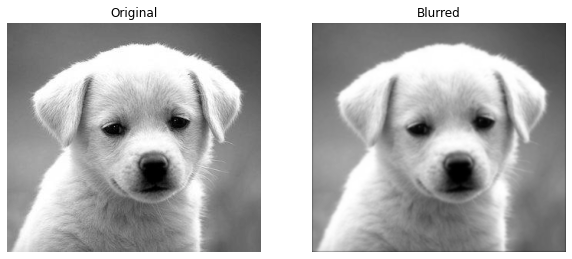

In [11]:
def gaussian2d(filter_size=7, sig=1.0):
    """
    Creates 2D Gaussian kernel with side length `filter_size` and a sigma of `sig`.
    """
    ax = np.arange(-filter_size // 2 + 1., filter_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel)

def blur_image(img):
    """Blur the image by convolving with a Gaussian filter."""
    """ ==========
    YOUR CODE HERE
    ========== """
    
    blurred_img=conv(img, gaussian2d(filter_size=7, sig=1.0))
    
    return blurred_img

# Plot original image
fig=plt.figure(figsize=(10,10))

ax=fig.add_subplot(2,2,1)
ax.imshow(img, cmap='gray')
ax.title.set_text('Original')
ax.axis('off')

# Plot blurred image
ax=fig.add_subplot(2,2,2)
ax.imshow(blur_image(img), cmap='gray')
ax.title.set_text('Blurred')
ax.axis('off')

plt.show()

#### Image Sharpening

In [12]:
sharpening_kernel = np.array([
    [1, 4,     6,  4, 1],
    [4, 16,   24, 16, 4],
    [6, 24, -476, 24, 6],
    [4, 16,   24, 16, 4],
    [1,  4,    6,  4, 1],
]) * -1.0 / 256.0

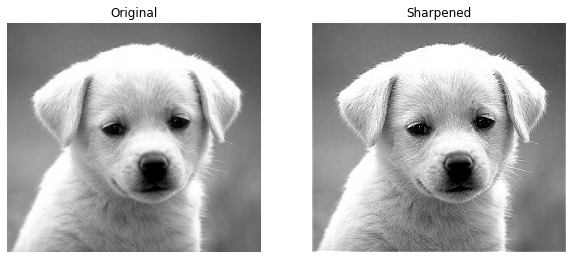

In [13]:
def sharpen_image(img):
    """Sharpen the image by convolving with a sharpening filter."""
    """ ==========
    YOUR CODE HERE
    ========== """
   
    sharpened_img=conv(img, sharpening_kernel)
    
    return sharpened_img

# Plot original image
fig=plt.figure(figsize=(10,10))

ax=fig.add_subplot(2,2,1)
ax.imshow(img, cmap='gray')
ax.title.set_text('Original')
ax.axis('off')

# Plot sharpened image
ax=fig.add_subplot(2,2,2)
ax.imshow(sharpen_image(img), vmin=0.0, vmax=1.0, cmap='gray')
ax.title.set_text('Sharpened')
ax.axis('off')

plt.show()

## Canny Edge Detection

#### Smoothing
First, we need to smooth the images in order to prevent noise from being considered as edges using a 9x9 Gaussian kernel filter with $\sigma = 1.4$ to smooth the images.

In [14]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.signal import convolve
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 5]

In [15]:
def gaussian2d(filter_size=None, sig=None):
    """Creates a 2D Gaussian kernel with
    side length `filter_size` and a sigma of `sig`."""
    ax = np.arange(-filter_size // 2 + 1., filter_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel)

In [16]:
def smooth(image):
    """ ==========
    YOUR CODE HERE
    ========== """
    return conv(image, gaussian2d(9,1.4))

Original:


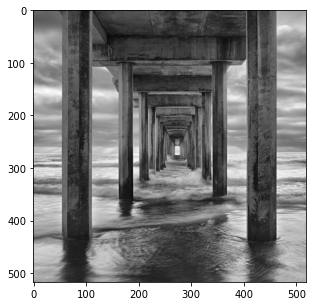

Smoothed:


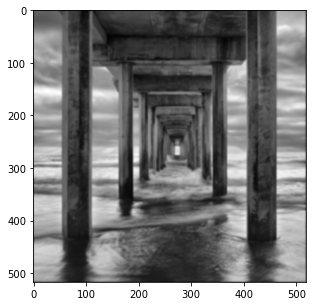

In [18]:
# Load image in grayscale
image = io.imread('sio_pier.jpg', as_gray=True)
assert len(image.shape) == 2, 'image should be grayscale; check your Python/skimage versions'
smoothed = smooth(image)
print('Original:')
plt.imshow(image, cmap=cm.gray)
plt.show()

print('Smoothed:')
plt.imshow(smoothed, cmap=cm.gray)
plt.show()

### Gradient Computation
Computing the image gradient in the horizontal and vertical directions. 

The gradient magnitude image is: $|G| = \sqrt{G_x^2 + G_y^2}$. 

The edge direction for each pixel is given by $G_\theta = \tan^{-1}\left(\frac{G_y}{G_x}\right)$.

In [19]:
def gradient(image):
    """ ==========
    YOUR CODE HERE
    ========== """
    
    dx=np.array([[-1,0,1],
                 [-2,0,2],
                 [-1,0,1]])
    dy=np.array([[1,2,1],
                 [0,0,0],
                 [-1,-2,-1]])
    
    Gx = conv(image,dx)
    Gy = conv(image,dy)
    
    g_mag = (Gx**2+Gy**2)**0.5
    g_theta = np.arctan2(Gy, Gx)
    
    
    return g_mag, g_theta

Gradient magnitude:


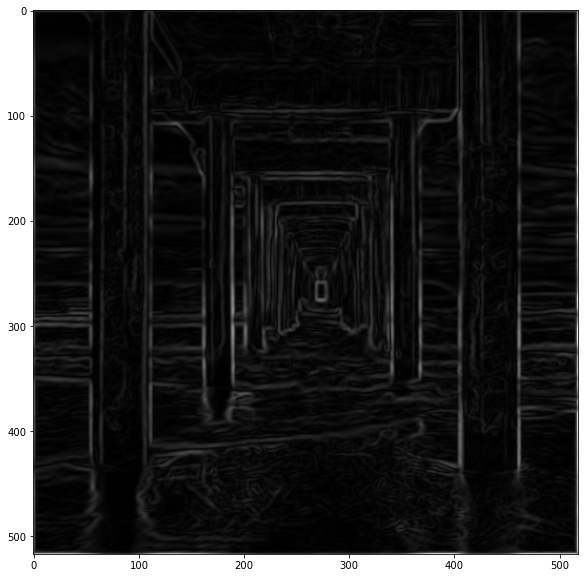

In [20]:
g_mag, g_theta = gradient(smoothed)
print('Gradient magnitude:')
plt.figure(figsize=(10,10))
plt.imshow(g_mag, cmap=cm.gray)
plt.show()

### Non-Maximum Suppression
Implement non-maximum suppression to preserve all local maxima and discard the rest to ensure sharp edges.

The process is:

  - For each pixel in the gradient magnitude image:
    - Round the gradient direction $\theta$ to the nearest multiple of $45^{\circ}$ (which we will refer to as $ve$).
    - Compare the edge strength at the current pixel to the pixels along the $+ve$ and $-ve$ gradient direction in the 8-connected neighborhood.
    - If the pixel does not have a larger value than both of its two neighbors in the $+ve$ and $-ve$ gradient directions, suppress the pixel's value (set it to 0). By following this process, we preserve the values of only those pixels which have maximum gradient magnitudes in the neighborhood along the $+ve$ and $-ve$ gradient directions.
  - Return the result as the NMS response.

In [21]:
def roundangle(x,n=45):
    return n * round(x/n)

def roundgradient(g_theta, n=45):
    # convert radian values to degree
    g_theta = g_theta*180.0/np.pi
    # round gradient to neareast multiple of 45 deg
    for i in range(g_theta.shape[0]):
        for j in range(g_theta.shape[1]):
            g_theta[i][j]=roundangle(g_theta[i][j])
    
    return g_theta

def nms(g_mag, g_theta):    
    nms_response = np.zeros_like(g_mag)
    g_theta = roundgradient(g_theta)
    
    
    for i in range(1,g_theta.shape[0]-1):
        for j in range(1,g_theta.shape[1]-1):
            if g_theta[i][j]==45 or g_theta[i][j]==-135:
                neigh = max(g_mag[i+1][j+1],g_mag[i-1][j-1])
                
            elif g_theta[i][j]==90 or g_theta[i][j]==-90:
                neigh = max(g_mag[i+1][j],g_mag[i-1][j])
            
            elif g_theta[i][j]==135 or g_theta[i][j]==-45:
                neigh = max(g_mag[i-1][j+1],g_mag[i+1][j-1])
                
            else:
                neigh = max(g_mag[i][j+1],g_mag[i][j-1])
                  
            if neigh<g_mag[i][j]: 
                nms_response[i][j]=g_mag[i][j]
                
    return nms_response

NMS:


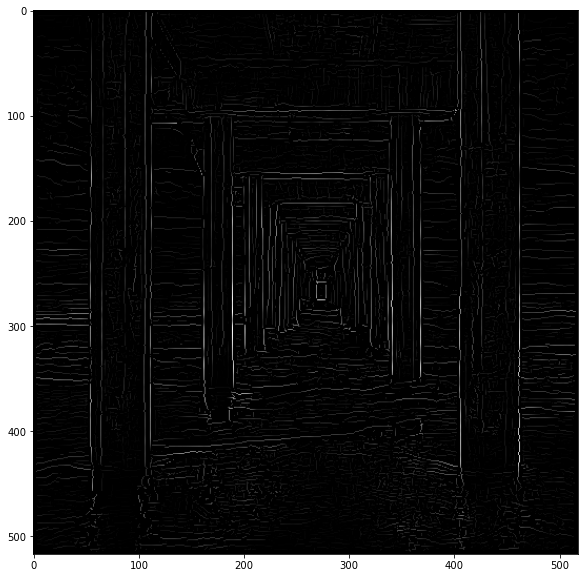

In [22]:
nms_image = nms(g_mag, g_theta)
print('NMS:')
plt.figure(figsize=(10,10))
plt.imshow(nms_image, cmap=cm.gray)
plt.show()

### Hysteresis Thresholding 

We will keep edges which meet the Hysteris Thresholding criteria and furhter eliminate noise.

The process is:

  - Define two thresholds `t_min` and `t_max`. 
  - If the `nms > t_max`, then we select that pixel as an edge.
  - If `nms < t_min`, we reject that pixel.
  - If `t_min < nms < t_max`, we select the pixel only if there is a path from to another pixel with `nms > t_max`. 
  - The choice of value of low and high thresholds depends on the range of values in the gradient magnitude image. 

In [23]:
directions = {
    0:(0,1), 45:(1,1), 90:(1,0), 135:(-1,1), 180:(-1,0),
    -180:(-1,0), -135:(-1,-1), -90:(-1,0), -45: (1,-1)
}

In [24]:
def hysteresis_threshold(image, g_theta, use_g_theta=False):
    """ ==========
    YOUR CODE HERE
    ========== """
    thhigh = image.max()*0.2
    thlow = thhigh*0.8
    
    g_theta = roundgradient(g_theta)
    result = np.zeros_like(image)
    
    visited=set()
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            
            if image[i][j]>=thhigh and (i,j) not in visited:
                result[i][j]=image[i][j]
                visited.add((i,j))
                
                q=[(i,j)]
                while q:
                    x,y = q.pop(0)
                    # normal
                    theta = g_theta[i][j]
                    tangent = theta+90
                    if tangent>180:
                        tangent = -1*(360-tangent)
                    dx,dy=directions[tangent]
                    
                    if 0<x+dx<image.shape[0] and 0<y+dy<image.shape[1]:
                        if image[x+dx][y+dy]>=thlow:
                            result[x+dx][y+dy]=image[x+dx][y+dy]
                            visited.add((x+dx,y+dy))
                            q.append((x+dx,y+dy))
                            

    return result

Thresholded:


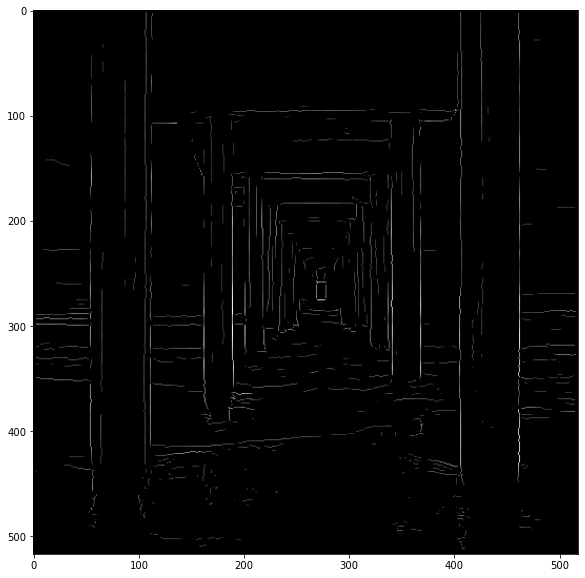

In [25]:
thresholded = hysteresis_threshold(nms_image, g_theta)
print('Thresholded:')
plt.figure(figsize=(10,10))
plt.imshow(thresholded, cmap=cm.gray)
plt.show()